In [1]:
#Public
import pandas as pd
import seaborn as sns
import sys

#Local
sys.path.append('../src') #append src folder to path
import functions

#Settings
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
#Load Data
avail_15_plugs_df = pd.read_csv('../data/interm/regression/train_feats_plugs15.csv', index_col=0)
avail_16_plugs_df = pd.read_csv('../data/interm/regression/train_feats_plugs16.csv', index_col=0)
#avail_15_stations_df = pd.read_csv('../data/interm/regression/train_feats_stations15.csv', index_col=0)
#avail_16_stations_df = pd.read_csv('../data/interm/regression/train_feats_stations16.csv', index_col=0)
full_avail_df = pd.concat([avail_15_plugs_df, avail_16_plugs_df]).reset_index()

reg_15_df = pd.read_csv('../data/interm/regression/train_labels_15.csv')
reg_16_df = pd.read_csv('../data/interm/regression/train_labels_16.csv')
full_reg_df = pd.concat([reg_15_df, reg_16_df]).reset_index()
full_reg_df['COUNTY_ID'] = full_avail_df['COUNTY_ID'] #add geoid to full_reg_df

dist_df = pd.read_csv('../data/interm/regression/county_dists.csv')

___
### Fit Value Function w/ Respect to EVSE Scope  
This section aims to fit a functional form for revealed value  as a function of the scope of the EVSE network (approximated as plugs/road mile in county). To fit this function, two years of availability and Polk registration rates are included (2015, 2016). Two functions were generated, one for the L2 network and one for the DC network.

For __L2__ scope, value is approximated from % of registrations that were BEV/PHEV in county (since both PEVs benefit from L2). A logistic growth function was fit to the data (Note: At this time it is hard to approximate the fit of this curve as there are very few instances of counties with "high" availability - most data points have close to no availability; As more data arrives and EVSE networks continue to grow, this fit should clarify). In fitting this curve, I only use only the counties with the highest number of annual registrations (>60K) & remove extreme outliers for fitting purposes (outlier quantile=99%). This was done to obtain a good fit using county data that is most stable (not prone to small sample variance).

k = 53.9931340129502
x0 = 0.06369440649049998


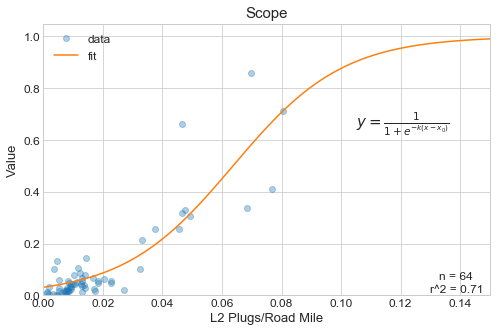

In [9]:
functions.fit(full_avail_df, full_reg_df, evse_type="L2", type="logistic")

For __DC__ scope, value is approximated from % of registrations that were BEV in county (since only BEVs benefit from DCFC). A logistic function was fit to the data (Note<sub>1</sub>: There are even fewer instances of counties with "high" availability for DCFC at the time of writing thus the concern for poor fit (referenced above) is even more pronounced in this case; As mentioned above, as more data arrives and EVSE networks continue to grow, this fit should clarify; Note<sub>2</sub>: The sample size is 63 here, compared to 64 above, because there is an additional outlier above the 99% threshold that is removed from consideration for the fitted function).

k = 438.5365351442664
x0 = 0.008220902855110295


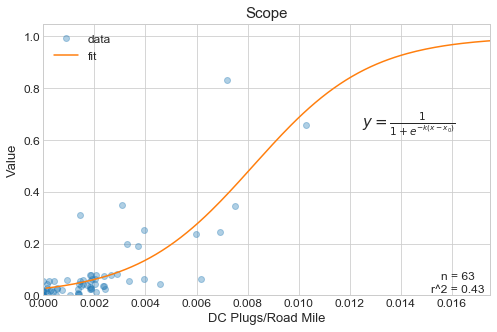

In [14]:
functions.fit(full_avail_df, full_reg_df, evse_type="DC", type="logistic")

___
### Fit Value Function w/ Respect to Distance  
This section aims to fit a functional form to the value of installed EVSE w/ respect to distance from home county. To fit this function, multiple regression was used to determine the correlation between registration % and EVSE scope in the home county and 29 nearest additional counties. The fitted coefficients were plotted with respect to median distance from home county (population centroid -> EVSE plug centroid). Two functions were generated, one for the L2 network and one for the DC network.

k = 0.09527771914805234
x0 = -22.626190257427258


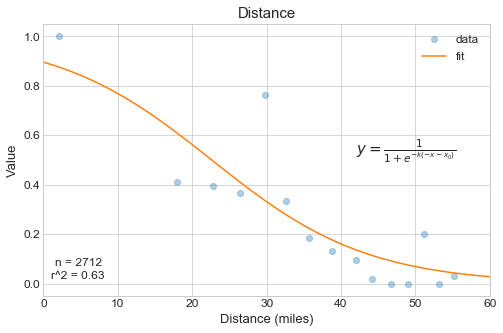

In [15]:
functions.fit_sigmoid_decay_to_regression_coefs(full_avail_df, full_reg_df, dist_df, evse_type="L2")

k = 0.12906658825227055
x0 = -30.11965095907099


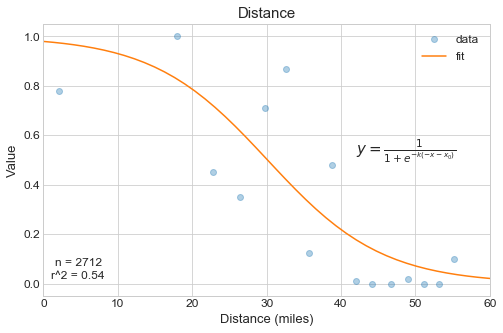

In [16]:
functions.fit_sigmoid_decay_to_regression_coefs(full_avail_df, full_reg_df, dist_df, evse_type="DC")

___
### Combine Scope & Distance Value Functions

From the sections above, the following functions were fitted to approximate the value related to scope and distance of EVSE charge stations for L2 and DC charging, respectively. First, for __L2 Charging__:  
$$V_{Scope_{L2}}(x) = \frac{1}{1+e^{-53.9931(x - 0.0637)}}$$  
*where __x__ = L2 plugs/road mile  

$$V_{Dist_{L2}}(x) = \frac{1}{1+e^{-0.0953(-x + 22.6262)}}$$
*where __x__ = miles from home location  

For __DC Charging__:  
$$V_{Scope_{DC}}(x) = \frac{1}{1+e^{-438.5365(x - 0.0082)}}$$
*where __x__ = DC plugs/road mile  

$$V_{Dist_{DC}}(x) = \frac{1}{1+e^{-0.1291(-x + 30.1197)}}$$
*where __x__ = miles from home location  

To estimate county-level EVSE availability with one metric (accounting for the scope and distance of the surrounding network), the following equation was used:

$${Avail}_i = \sum_{j=1}^{k}{{V_{Scope}}_j * {V_{Dist}}_j}$$  
*for __i__ counties in U.S. and __j__ of __k__ counties within 30 miles of home (L2) or 35 miles of home (DC)

In [10]:
l2_df, dc_df = functions.generate_evse_avail_dfs(avail_15_plugs_df, avail_16_plugs_df, reg_15_df, reg_16_df, dist_df)

          l2_avail     X0_l2  PEV_perc
l2_avail  1.000000  0.681996  0.606416
X0_l2     0.681996  1.000000  0.530241
PEV_perc  0.606416  0.530241  1.000000


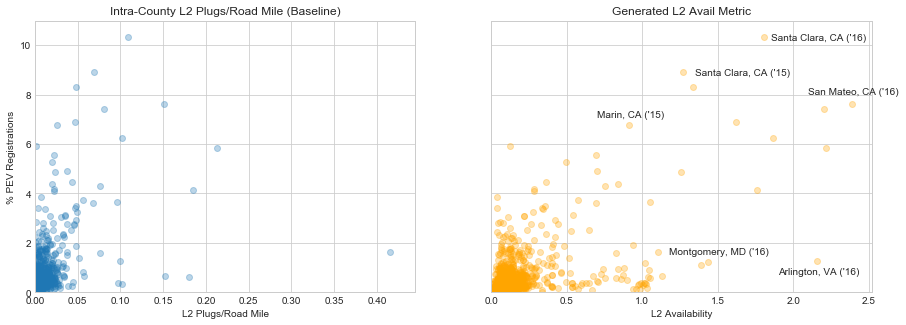

In [11]:
functions.view_correlation(l2_df, min_regs=1000)

          dc_avail     X0_dc  BEV_perc
dc_avail  1.000000  0.594472  0.601134
X0_dc     0.594472  1.000000  0.416686
BEV_perc  0.601134  0.416686  1.000000


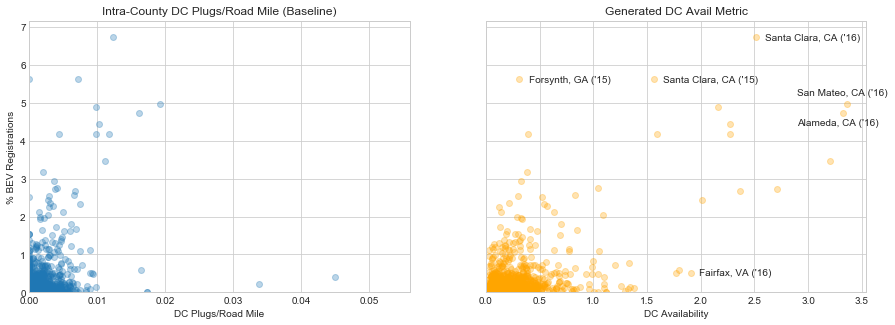

In [12]:
functions.view_correlation(dc_df, min_regs=1000)

The correlation between the availability metric (as defined above) and real world PEV registrations (L2) and BEV registrations (DC) is improved over the baseline of intra-county plugs/road mile. The scatterplots above show that the method does a fairly good job of providing separation between points when compared to the base case. The fit for this method is based on two years (2015 & 2016) of county-level registration data. At this time it is hard to estimate the relationship between EVSE and PEV purchases controlling for all other factors. One reason for this is the relative immaturity of the PEV charging network and low levels of adoption through 2016. That said, __this metric can be used in ADOPT to represent wholistic EVSE availability at a county-level__ until more data is received. In the future, the fit will improve as EVSE networks mature and PEV's become more mainstream.